<a href="https://colab.research.google.com/github/teatime77/xbrl-reader/blob/master/notebook/sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Matplotlibで日本語が表示できるようにします。

#### IPAフォントをインストールします。

In [0]:
!apt-get -y install fonts-ipafont-gothic

#### Matplotlibのフォントのキャッシュを再構築します。

In [0]:
import matplotlib
matplotlib.font_manager._rebuild()

#### <font color="red">キャッシュの再構築を有効にするために、ここでランタイムを再起動してください。</font>

#### <font color="red">以下の中から予測したい項目のコメントをはずしてください。</font>

In [0]:
target = '売上高'
# target = '営業利益'
# target = '経常利益'
# target = '税引前純利益'

#### <font color="red">グリッドサーチをする場合は、以下の変数の値をTrueにしてください。</font>

In [0]:
use_grid_search = False

### 選択した項目に対応するファイルをダウンロードします。

In [0]:
if   target == '売上高':
    ! wget http://lkzf.info/xbrl/data/2020-04-08/preprocess-uriage.pickle

elif target == '営業利益':
    ! wget http://lkzf.info/xbrl/data/2020-04-08/preprocess-eigyo.pickle

elif target == '経常利益':
    ! wget http://lkzf.info/xbrl/data/2020-04-08/preprocess-keijo.pickle

elif target == '税引前純利益':
    ! wget http://lkzf.info/xbrl/data/2020-04-08/preprocess-jun.pickle

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/hamada/.wget-hsts'. HSTS will be disabled.
--2020-04-08 09:55:42--  http://lkzf.info/xbrl/data/2020-04-08/preprocess-uriage.pickle
lkzf.info (lkzf.info) をDNSに問いあわせています... 157.7.107.146
lkzf.info (lkzf.info)|157.7.107.146|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 4470838 (4.3M)
`preprocess-uriage.pickle.1' に保存中

preprocess-uriage.p 100%[===================>]   4.26M  7.31MB/s    時間 0.6s  

2020-04-08 09:55:42 (7.31 MB/s) - `preprocess-uriage.pickle.1' へ保存完了 [4470838/4470838]



### CatBoostをインストールします。

In [0]:
! pip install catboost

### 必要なライブラリをインポートします。

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set(font='IPAGothic')

### データを読み込みます。

In [0]:
import pickle

if   target == '売上高':
    file_name = 'preprocess-uriage.pickle'
elif target == '営業利益':
    file_name = 'preprocess-eigyo.pickle'
elif target == '経常利益':
    file_name = 'preprocess-keijo.pickle'
elif target == '税引前純利益':
    file_name = 'preprocess-jun.pickle'
else:
    assert False

with open(file_name, 'rb') as f:
    data = pickle.load(f)

df = data['data_frame']
y_column = data['y_column']

### トレーニングデータとテストデータに分けます。

In [0]:
X_columns = [ x for x in df.columns if x != y_column ]

df = df[ X_columns + [y_column] ]

# トレーニングデータとテストデータに分けます。
X_train, X_test, y_train, y_test = train_test_split(df.drop(y_column, axis=1), df[y_column], test_size=0.2, random_state=0)

### モデルを実行します。

In [0]:
from sklearn.model_selection import GridSearchCV

def run_model(model):
    global y_test, y_pred

    # print(type(model), str(type(model)).replace("'").split('.')[-1])

    if use_grid_search and type(model) in [ RandomForestRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor ]:

        model = GridSearchCV(model, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=2, n_jobs=-1)

    # トレーニングデータで学習します。
    result = model.fit(X_train, y_train)

    if hasattr(result, 'best_params_'):
        print ('best params =', result.best_params_)

    # テストデータで予測します。
    y_pred = model.predict(X_test)

    # 平均二乗誤差を計算します。
    accu1 = mean_squared_error(y_test, y_pred)
    accu2 = mean_squared_error(y_test, [y_test.mean()] * len(y_test) )

    # 平均絶対誤差を計算します。
    accu3 = mean_absolute_error(y_test, y_pred)
    accu4 = mean_absolute_error(y_test, [y_test.mean()] * len(y_test) )

    print('\n平均二乗誤差 : %.4f ( %.4f )  平均絶対誤差 : %.4f ( %.4f )    ※ カッコ内は全予測値を平均値で置き換えた場合\n' % (accu1, accu2, accu3, accu4))    

    if hasattr(model, 'feature_importances_'):
        # 特徴量の重要度がある場合
        
        # 重要度の順にソートします。
        sorted_idx_names = sorted(enumerate(model.feature_importances_), key=lambda x: x[1], reverse=True)

        print('特徴量の重要度')
        for i, (idx, x) in enumerate(sorted_idx_names[:20]):
            print('    %2d %.05f %s' % (i, 100 * x, X_train.columns[idx]))


    # 正解と予測を散布図に表示します。
    sns.jointplot(y_test, y_pred, kind="reg").set_axis_labels('正解', '予測')

### リッジ回帰


平均二乗誤差 : 0.0645 ( 0.0667 )  平均絶対誤差 : 0.1784 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合



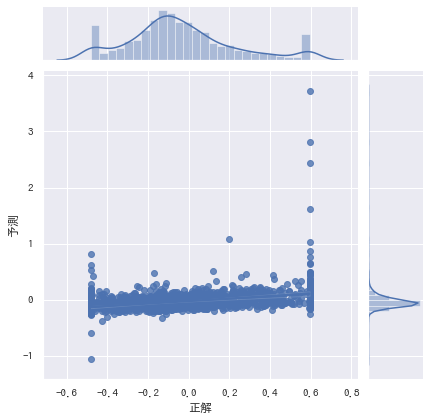

In [0]:
model = Ridge(alpha=.5) # 0.0668
run_model(model)

### サポートベクターマシン


平均二乗誤差 : 0.0517 ( 0.0667 )  平均絶対誤差 : 0.1670 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合



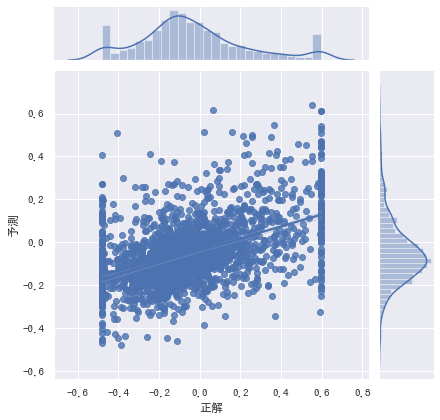

In [0]:
model = SVR(kernel='rbf') # 0.0536
run_model(model)

### ランダムフォレスト


平均二乗誤差 : 0.0510 ( 0.0667 )  平均絶対誤差 : 0.1679 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合

特徴量の重要度
     0 17.08380 総資産額変化率
     1 13.00094 資産変化率
     2 12.81557 従業員数変化率
     3 12.39717 負債純資産変化率
     4 3.43221 個別固定資産変化率
     5 3.33855 流動負債変化率
     6 3.14288 総資本回転率変化率
     7 3.01185 個別期首期末平均資産変化率
     8 2.89612 受取手形及び売掛金変化率
     9 2.47348 負債変化率
    10 2.29155 売上高変化率
    11 2.00294 売上原価変化率
    12 1.75754 期首期末平均資産変化率
    13 1.52426 販売費及び一般管理費変化率
    14 1.39180 売上高総利益率
    15 1.15180 その他、流動資産変化率
    16 1.07797 減価償却費、営業活動によるキャッシュ・フロー変化率
    17 1.06880 有形固定資産変化率
    18 0.98709 現金及び預金変化率
    19 0.87980 固定資産変化率


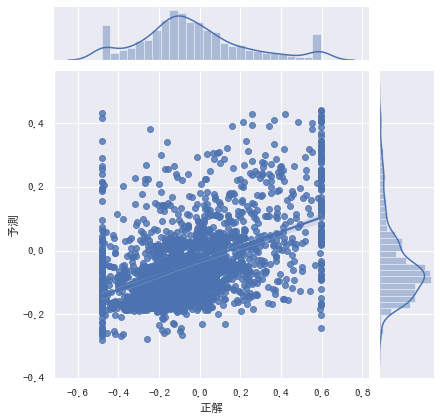

In [0]:
model = RandomForestRegressor(max_depth=6, n_estimators=200) # 0.0527
run_model(model)

### XGBoost


平均二乗誤差 : 0.0517 ( 0.0667 )  平均絶対誤差 : 0.1658 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合

特徴量の重要度
     0 17.36086 負債純資産変化率
     1 11.42379 総資産額変化率
     2 5.65898 従業員数変化率
     3 5.18614 個別期首期末平均資産変化率
     4 4.40074 負債変化率
     5 3.04302 流動負債変化率
     6 2.94651 総資本回転率変化率
     7 2.26747 業種_情報・通信業
     8 1.95919 受取手形及び売掛金変化率
     9 1.88183 業種_鉄鋼
    10 1.77481 業種_機械
    11 1.72075 業種_卸売業
    12 1.48695 業種_不動産業
    13 1.33933 売上高変化率
    14 1.30940 個別固定資産変化率
    15 1.30830 売上高総利益率
    16 1.27461 自己資本変化率
    17 1.24279 業種_建設業
    18 1.17001 個別総資産額変化率
    19 1.09296 販売費及び一般管理費変化率


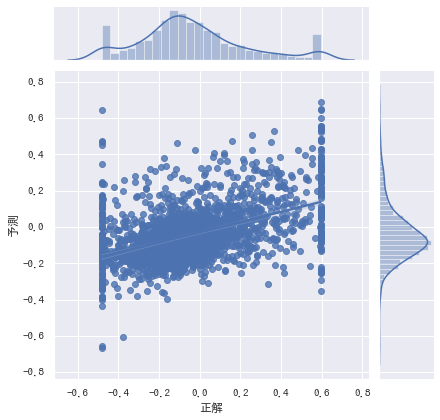

In [0]:
model = XGBRegressor(max_depth=2, n_estimators=200) # 0.0538 
run_model(model)

### LightGBM


平均二乗誤差 : 0.0495 ( 0.0667 )  平均絶対誤差 : 0.1645 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合

特徴量の重要度
     0 5500.00000 従業員数変化率
     1 4700.00000 総資本回転率変化率
     2 3200.00000 売上高変化率
     3 3100.00000 受取手形及び売掛金変化率
     4 3100.00000 流動負債変化率
     5 2100.00000 その他、流動資産変化率
     6 1900.00000 現金及び預金変化率
     7 1900.00000 総資産額変化率
     8 1800.00000 売上高総利益率
     9 1700.00000 個別期首期末平均資産変化率
    10 1600.00000 有形固定資産変化率
    11 1600.00000 投資その他の資産変化率
    12 1600.00000 売上原価変化率
    13 1500.00000 期首期末平均資産変化率
    14 1500.00000 個別固定資産変化率
    15 1400.00000 自己資本利益率
    16 1400.00000 流動資産変化率
    17 1400.00000 固定資産変化率
    18 1300.00000 負債変化率
    19 1300.00000 販売費及び一般管理費変化率


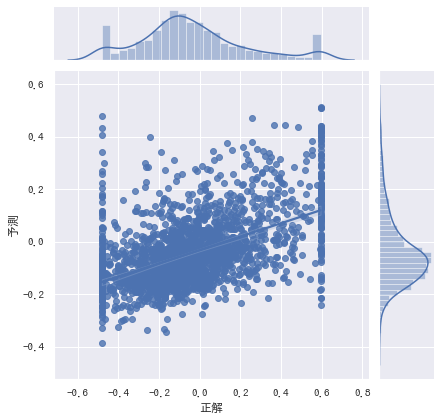

In [0]:
model = LGBMRegressor(objective='regression', num_leaves = 31, max_depth=4, n_estimators=50)  # 0.0524 
run_model(model)

### CatBoost


平均二乗誤差 : 0.0500 ( 0.0667 )  平均絶対誤差 : 0.1646 ( 0.1968 )    ※ カッコ内は全予測値を平均値で置き換えた場合

特徴量の重要度
     0 1498.87361 資産変化率
     1 1313.04041 従業員数変化率
     2 522.07508 流動負債変化率
     3 500.49970 売上高変化率
     4 473.49879 受取手形及び売掛金変化率
     5 394.07555 期首期末平均資産変化率
     6 339.51346 総資産額変化率
     7 335.53650 総資本回転率変化率
     8 305.72160 個別期首期末平均資産変化率
     9 267.03192 現金及び預金変化率
    10 237.40440 有形固定資産変化率
    11 236.34829 売上原価変化率
    12 227.41605 個別総資産額変化率
    13 215.48620 負債変化率
    14 210.03696 売上高総利益率
    15 204.71775 個別固定資産変化率
    16 202.44422 個別投資その他の資産変化率
    17 154.99680 固定資産変化率
    18 136.73833 販売費及び一般管理費変化率
    19 131.14297 減価償却費、営業活動によるキャッシュ・フロー変化率


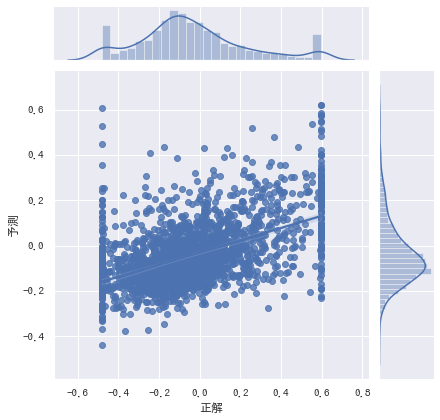

In [0]:
model = CatBoostRegressor(max_depth=2, n_estimators=200, verbose=0)  # 0.0530 
run_model(model)

In [0]:
if target == '税引前純利益':

    # 予測値が0.02以上の部分の散布図を作ります。
    min_value = 0.02
    sns.jointplot(y_test[min_value <= y_pred], y_pred[min_value <= y_pred], marginal_kws=dict(bins=20, rug=True), kind="reg").set_axis_labels('正解', '予測')